# Download dataset

In [38]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_f:
    zip_f.extractall("input")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


# Important imports


In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

from scipy import stats
from catboost import CatBoostRegressor, Pool

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV

# import eli5
# from eli5.sklearn import PermutationImportance

# import hyperopt
from sklearn import preprocessing
from numpy.random import RandomState
from os import listdir

from catboost.eval.catboost_evaluation import *
from catboost.utils import create_cd

# import shap
# # load JS visualization code to notebook
# shap.initjs()

# Load dataset

## Train


In [40]:
train = pd.read_csv("input/train.csv", index_col=0)
min_max_scaler = preprocessing.MinMaxScaler()

# # normalize numeric colimns  with min max sacller
# for col in train.columns[:len(train.columns)-1]:
#     if pd.to_numeric(train[col], errors='coerce').notnull().all():
#         train[col] = min_max_scaler.fit_transform(train[col].values.reshape(-1,1))

train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Test 


In [41]:
test = pd.read_csv("input/test.csv", index_col=0)

# # normalize numeric colimns  with min max sacller
# for col in test.columns[:len(test.columns)-1]:
#     if pd.to_numeric(test[col], errors='coerce').notnull().all():
#         test[col] = min_max_scaler.fit_transform(test[col].values.reshape(-1,1))

test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# data view 

output columns with a large number of missing values

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

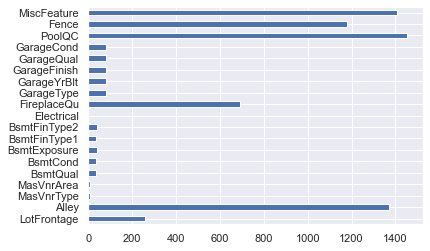

In [42]:
null_features = train.isnull().sum(axis = 0)
null_features[null_features>=1].plot(kind = 'barh')
null_features

delete colomns with more then 300 missing values

In [43]:
#check description to fill missings
train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['PoolQC'] = train['PoolQC'].fillna('No Pool')
train['PoolQC'] = [1 if x != 'No Pool' else 0 for x in train.loc[:,'PoolQC'].values]

train['MiscFeature'] = train['MiscFeature'].fillna('None')

train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in train.loc[:,'FireplaceQu'].values]

train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['Alley'] = train['Alley'].fillna('No alley access')
train['Alley'] = [1 if x != 'No alley access' else 0 for x in train.loc[:,'Alley'].values]

train['LotFrontage'] = train['LotFrontage'].fillna('0')

train['GarageType'] = train['GarageType'].fillna('No Garage')

train['GarageCond'] = train['GarageCond'].fillna('No Garage')

train['GarageQual'] = train['GarageQual'].fillna('No Garage')

train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')

train['GarageYrBlt'] = train['GarageYrBlt'].fillna('No Garage')
train['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in train.loc[:,'GarageYrBlt'].values]

train[ 'BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')

train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')

train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')

train['MasVnrArea'] = train['MasVnrArea'].fillna('0')


train['MasVnrType'] = train['MasVnrType'].fillna('None')

train['Electrical'] = train['Electrical'].fillna('Mixed')


In [44]:
#check description to fill missings
test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['PoolQC'] = test['PoolQC'].fillna('No Pool')
test['PoolQC'] = [1 if x != 'No Pool' else 0 for x in test.loc[:,'PoolQC'].values]

test['MiscFeature'] = test['MiscFeature'].fillna('None')

test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in test.loc[:,'FireplaceQu'].values]

test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['Alley'] = test['Alley'].fillna('No alley access')
test['Alley'] = [1 if x != 'No alley access' else 0 for x in test.loc[:,'Alley'].values]

test['LotFrontage'] = test['LotFrontage'].fillna('0')

test['GarageType'] = test['GarageType'].fillna('No Garage')

test['GarageCond'] = test['GarageCond'].fillna('No Garage')

test['GarageQual'] = test['GarageQual'].fillna('No Garage')

test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')

test['GarageYrBlt'] = test['GarageYrBlt'].fillna('No Garage')
test['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in test.loc[:,'GarageYrBlt'].values]

test[ 'BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')

test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')

test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')

test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')

test['MasVnrArea'] = test['MasVnrArea'].fillna('0')


test['MasVnrType'] = test['MasVnrType'].fillna('None')

test['Electrical'] = test['Electrical'].fillna('Mixed')

In [45]:
null_features = train.isnull().sum(axis = 0)
if null_features[null_features == '0'].all():
    print('no null features')
else:
    null_features[null_features>=1].plot(kind = 'barh')
    null_features


no null features


### Sale Prise Distribution

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Target distribution in train')

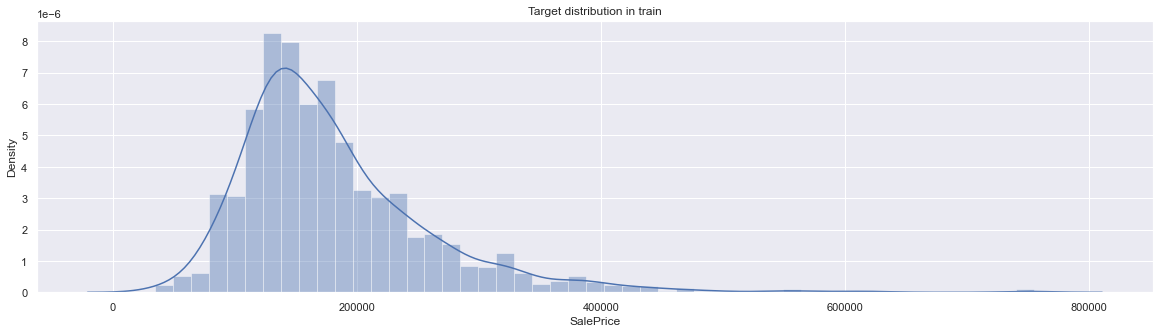

In [46]:
plt.figure(figsize=(20,5))

sns.distplot(train.SalePrice)
plt.title("Target distribution in train")

apply the logarithm function to remove outliers

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Log distribution in train')

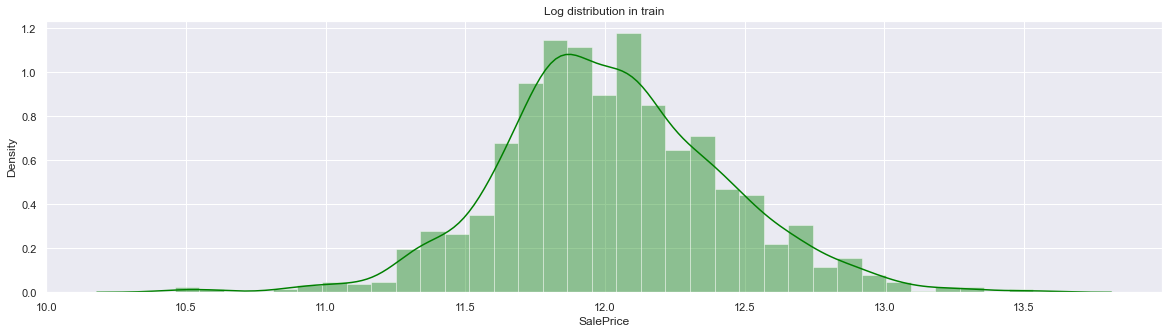

In [47]:
plt.figure(figsize=(20,5))
sns.distplot(np.log(train.SalePrice), color="green")
plt.title("Log distribution in train")

In [48]:
train["SalePrice"] = train.SalePrice.apply(np.log)

In [49]:
num_candidates = list(train.dtypes[train.dtypes!="object"].index.values)
num_candidates

['MSSubClass',
 'LotArea',
 'Alley',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


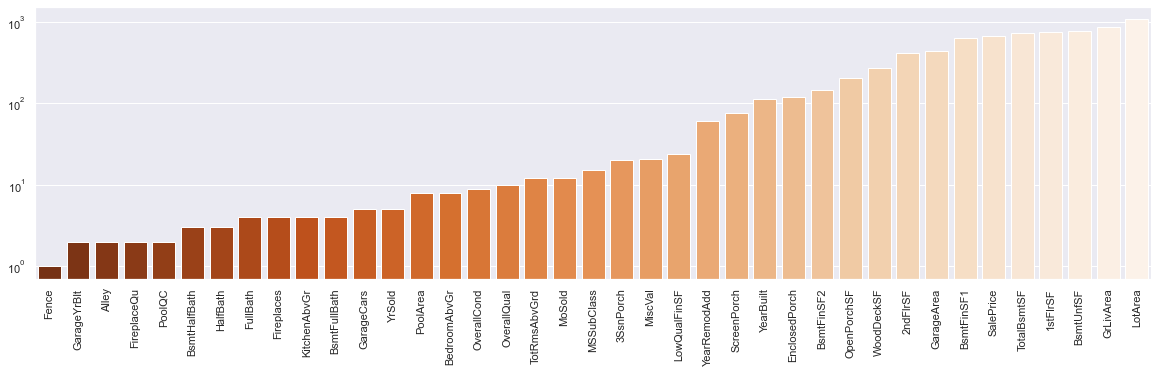

In [50]:
unique_counts = train.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90);
plt.yscale("log")

In [51]:
cat_features = list(train.select_dtypes(include='object').columns)
train[cat_features].describe().T.sort_values('unique', ascending=False)

,count,unique,top,freq
MasVnrArea,1460.0,328.0,0.0,861.0
LotFrontage,1460,111,0,259
Neighborhood,1460,25,NAmes,225
Exterior2nd,1460,16,VinylSd,504
Exterior1st,1460,15,VinylSd,515
SaleType,1460,9,WD,1267
Condition1,1460,9,Norm,1260
HouseStyle,1460,8,1Story,726
RoofMatl,1460,8,CompShg,1434
Condition2,1460,8,Norm,1445


In [52]:
cat_features = list(train.columns[:len(train.columns)-1])
print(*cat_features)

MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType SaleCondition


In [53]:
for feature in cat_features:
    print(f'Feature {feature}')
    display(train[feature].value_counts())
    print('-' * 40)

Feature MSSubClass


20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

----------------------------------------
Feature MSZoning


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

----------------------------------------
Feature LotFrontage


0        259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
128.0      1
46.0       1
111.0      1
112.0      1
38.0       1
Name: LotFrontage, Length: 111, dtype: int64

----------------------------------------
Feature LotArea


7200     25
9600     24
6000     17
8400     14
9000     14
         ..
13031     1
10991     1
8944      1
6897      1
8190      1
Name: LotArea, Length: 1073, dtype: int64

----------------------------------------
Feature Street


Pave    1454
Grvl       6
Name: Street, dtype: int64

----------------------------------------
Feature Alley


0    1369
1      91
Name: Alley, dtype: int64

----------------------------------------
Feature LotShape


Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

----------------------------------------
Feature LandContour


Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

----------------------------------------
Feature Utilities


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

----------------------------------------
Feature LotConfig


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

----------------------------------------
Feature LandSlope


Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

----------------------------------------
Feature Neighborhood


NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

----------------------------------------
Feature Condition1


Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

----------------------------------------
Feature Condition2


Norm      1445
Feedr        6
RRNn         2
Artery       2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

----------------------------------------
Feature BldgType


1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

----------------------------------------
Feature HouseStyle


1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

----------------------------------------
Feature OverallQual


5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

----------------------------------------
Feature OverallCond


5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

----------------------------------------
Feature YearBuilt


2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1904     1
1898     1
1893     1
1882     1
2010     1
Name: YearBuilt, Length: 112, dtype: int64

----------------------------------------
Feature YearRemodAdd


1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1986      5
1952      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

----------------------------------------
Feature RoofStyle


Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

----------------------------------------
Feature RoofMatl


CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

----------------------------------------
Feature Exterior1st


VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

----------------------------------------
Feature Exterior2nd


VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

----------------------------------------
Feature MasVnrType


None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

----------------------------------------
Feature MasVnrArea


0.0      861
180.0      8
72.0       8
0          8
108.0      8
        ... 
528.0      1
31.0       1
673.0      1
219.0      1
510.0      1
Name: MasVnrArea, Length: 328, dtype: int64

----------------------------------------
Feature ExterQual


TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

----------------------------------------
Feature ExterCond


TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

----------------------------------------
Feature Foundation


PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

----------------------------------------
Feature BsmtQual


TA             649
Gd             618
Ex             121
No Basement     37
Fa              35
Name: BsmtQual, dtype: int64

----------------------------------------
Feature BsmtCond


TA             1311
Gd               65
Fa               45
No Basement      37
Po                2
Name: BsmtCond, dtype: int64

----------------------------------------
Feature BsmtExposure


No             953
Av             221
Gd             134
Mn             114
No Basement     38
Name: BsmtExposure, dtype: int64

----------------------------------------
Feature BsmtFinType1


Unf            430
GLQ            418
ALQ            220
BLQ            148
Rec            133
LwQ             74
No Basement     37
Name: BsmtFinType1, dtype: int64

----------------------------------------
Feature BsmtFinSF1


0       467
24       12
16        9
20        5
686       5
       ... 
535       1
534       1
532       1
522       1
2096      1
Name: BsmtFinSF1, Length: 637, dtype: int64

----------------------------------------
Feature BsmtFinType2


Unf            1256
Rec              54
LwQ              46
No Basement      38
BLQ              33
ALQ              19
GLQ              14
Name: BsmtFinType2, dtype: int64

----------------------------------------
Feature BsmtFinSF2


0       1293
180        5
374        3
117        2
391        2
        ... 
215        1
211        1
210        1
208        1
1474       1
Name: BsmtFinSF2, Length: 144, dtype: int64

----------------------------------------
Feature BsmtUnfSF


0       118
728       9
384       8
572       7
600       7
       ... 
549       1
548       1
545       1
543       1
2046      1
Name: BsmtUnfSF, Length: 780, dtype: int64

----------------------------------------
Feature TotalBsmtSF


0       37
864     35
672     17
912     15
1040    14
        ..
1210     1
727      1
1205     1
1203     1
2046     1
Name: TotalBsmtSF, Length: 721, dtype: int64

----------------------------------------
Feature Heating


GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

----------------------------------------
Feature HeatingQC


Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

----------------------------------------
Feature CentralAir


Y    1365
N      95
Name: CentralAir, dtype: int64

----------------------------------------
Feature Electrical


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mixed       1
Mix         1
Name: Electrical, dtype: int64

----------------------------------------
Feature 1stFlrSF


864     25
1040    16
912     14
848     12
894     12
        ..
1061     1
1058     1
1051     1
1047     1
2046     1
Name: 1stFlrSF, Length: 753, dtype: int64

----------------------------------------
Feature 2ndFlrSF


0       829
728      10
504       9
672       8
546       8
       ... 
812       1
811       1
473       1
475       1
1872      1
Name: 2ndFlrSF, Length: 417, dtype: int64

----------------------------------------
Feature LowQualFinSF


0      1434
80        3
360       2
392       1
528       1
515       1
514       1
513       1
481       1
479       1
473       1
420       1
397       1
390       1
53        1
384       1
371       1
234       1
232       1
205       1
156       1
144       1
120       1
572       1
Name: LowQualFinSF, dtype: int64

----------------------------------------
Feature GrLivArea


864     22
1040    14
894     11
848     10
1456    10
        ..
2792     1
2794     1
1349     1
1347     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64

----------------------------------------
Feature BsmtFullBath


0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

----------------------------------------
Feature BsmtHalfBath


0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

----------------------------------------
Feature FullBath


2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

----------------------------------------
Feature HalfBath


0    913
1    535
2     12
Name: HalfBath, dtype: int64

----------------------------------------
Feature BedroomAbvGr


3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

----------------------------------------
Feature KitchenAbvGr


1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

----------------------------------------
Feature KitchenQual


TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

----------------------------------------
Feature TotRmsAbvGrd


6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

----------------------------------------
Feature Functional


Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

----------------------------------------
Feature Fireplaces


0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

----------------------------------------
Feature FireplaceQu


1    770
0    690
Name: FireplaceQu, dtype: int64

----------------------------------------
Feature GarageType


Attchd       870
Detchd       387
BuiltIn       88
No Garage     81
Basment       19
CarPort        9
2Types         6
Name: GarageType, dtype: int64

----------------------------------------
Feature GarageYrBlt


1    1379
0      81
Name: GarageYrBlt, dtype: int64

----------------------------------------
Feature GarageFinish


Unf          605
RFn          422
Fin          352
No Garage     81
Name: GarageFinish, dtype: int64

----------------------------------------
Feature GarageCars


2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

----------------------------------------
Feature GarageArea


0       81
440     49
576     47
240     38
484     34
        ..
671      1
342      1
673      1
675      1
1418     1
Name: GarageArea, Length: 441, dtype: int64

----------------------------------------
Feature GarageQual


TA           1311
No Garage      81
Fa             48
Gd             14
Po              3
Ex              3
Name: GarageQual, dtype: int64

----------------------------------------
Feature GarageCond


TA           1326
No Garage      81
Fa             35
Gd              9
Po              7
Ex              2
Name: GarageCond, dtype: int64

----------------------------------------
Feature PavedDrive


Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

----------------------------------------
Feature WoodDeckSF


0      761
192     38
100     36
144     33
120     31
      ... 
103      1
269      1
98       1
97       1
857      1
Name: WoodDeckSF, Length: 274, dtype: int64

----------------------------------------
Feature OpenPorchSF


0      656
36      29
48      22
20      21
45      19
      ... 
141      1
137      1
135      1
134      1
547      1
Name: OpenPorchSF, Length: 202, dtype: int64

----------------------------------------
Feature EnclosedPorch


0      1252
112      15
96        6
120       5
192       5
       ... 
170       1
169       1
67        1
68        1
552       1
Name: EnclosedPorch, Length: 120, dtype: int64

----------------------------------------
Feature 3SsnPorch


0      1436
168       3
216       2
144       2
180       2
407       1
320       1
304       1
290       1
245       1
238       1
182       1
196       1
23        1
162       1
153       1
140       1
130       1
96        1
508       1
Name: 3SsnPorch, dtype: int64

----------------------------------------
Feature ScreenPorch


0      1344
192       6
120       5
224       5
180       4
       ... 
175       1
178       1
40        1
185       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64

----------------------------------------
Feature PoolArea


0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: PoolArea, dtype: int64

----------------------------------------
Feature PoolQC


0    1453
1       7
Name: PoolQC, dtype: int64

----------------------------------------
Feature Fence


1    1460
Name: Fence, dtype: int64

----------------------------------------
Feature MiscFeature


None    1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

----------------------------------------
Feature MiscVal


0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
480         2
1200        2
2500        1
350         1
560         1
54          1
620         1
8300        1
800         1
1150        1
15500       1
1300        1
1400        1
3500        1
Name: MiscVal, dtype: int64

----------------------------------------
Feature MoSold


6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

----------------------------------------
Feature YrSold


2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

----------------------------------------
Feature SaleType


WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

----------------------------------------
Feature SaleCondition


Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

----------------------------------------


In [54]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,1,None,0,2,2008,WD,Normal,12.247694
2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,1,None,0,5,2007,WD,Normal,12.109011
3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,1,None,0,9,2008,WD,Normal,12.317167
4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,1,None,0,2,2006,WD,Abnorml,11.849398
5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,1,None,0,12,2008,WD,Normal,12.429216


In [55]:


train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train.drop(columns=['SalePrice']),
    train['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [56]:
for col in cat_features:
    train_X[col] = train_X[col].astype(str)
    val_X[col] = val_X[col].astype(str)

In [57]:
train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)
# test_pool = catboost.Pool(
#     test_X,
#     # label=test_y,
#     cat_features=cat_features
# )

In [58]:
catboost_train_dir = 'catboost_clf'

params = {'bagging_temperature': 0.8,
               'depth': 8,
               'iterations': 1500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.08,
               'random_strength': 0.8}

clf = catboost.CatBoostRegressor(
                                **params,
                                 loss_function='RMSE', 
                                 random_seed=2021, 
                                 task_type='GPU')
clf.fit(train_pool, eval_set=val_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3910215	test: 0.3676903	best: 0.3676903 (0)	total: 33.5ms	remaining: 1m 40s
1:	learn: 0.3790787	test: 0.3557918	best: 0.3557918 (1)	total: 67.7ms	remaining: 1m 41s
2:	learn: 0.3684471	test: 0.3454682	best: 0.3454682 (2)	total: 116ms	remaining: 1m 56s
3:	learn: 0.3591149	test: 0.3359306	best: 0.3359306 (3)	total: 161ms	remaining: 2m
4:	learn: 0.3506000	test: 0.3275344	best: 0.3275344 (4)	total: 199ms	remaining: 1m 59s
5:	learn: 0.3426166	test: 0.3199888	best: 0.3199888 (5)	total: 233ms	remaining: 1m 56s
6:	learn: 0.3353459	test: 0.3135027	best: 0.3135027 (6)	total: 271ms	remaining: 1m 56s
7:	learn: 0.3288276	test: 0.3080322	best: 0.3080322 (7)	total: 329ms	remaining: 2m 3s
8:	learn: 0.3221845	test: 0.3004953	best: 0.3004953 (8)	total: 363ms	remaining: 2m
9:	learn: 0.3176637	test: 0.2962188	best: 0.2962188 (9)	total: 397ms	remaining: 1m 58s
10:	learn: 0.3118134	test: 0.2910600	best: 0.2910600 (10)	total: 442ms	remaining: 2m
11:	learn: 0.3065877	test: 0.2858490	best: 0.2858490

94:	learn: 0.1841625	test: 0.1691318	best: 0.1691318 (94)	total: 4.35s	remaining: 2m 13s
95:	learn: 0.1840716	test: 0.1690725	best: 0.1690725 (95)	total: 4.38s	remaining: 2m 12s
96:	learn: 0.1838089	test: 0.1687299	best: 0.1687299 (96)	total: 4.42s	remaining: 2m 12s
97:	learn: 0.1837198	test: 0.1686718	best: 0.1686718 (97)	total: 4.45s	remaining: 2m 11s
98:	learn: 0.1837083	test: 0.1686381	best: 0.1686381 (98)	total: 4.49s	remaining: 2m 11s
99:	learn: 0.1836978	test: 0.1686082	best: 0.1686082 (99)	total: 4.53s	remaining: 2m 11s
100:	learn: 0.1834973	test: 0.1683079	best: 0.1683079 (100)	total: 4.59s	remaining: 2m 11s
101:	learn: 0.1834875	test: 0.1682788	best: 0.1682788 (101)	total: 4.63s	remaining: 2m 11s
102:	learn: 0.1834024	test: 0.1682240	best: 0.1682240 (102)	total: 4.67s	remaining: 2m 11s
103:	learn: 0.1831442	test: 0.1679139	best: 0.1679139 (103)	total: 4.73s	remaining: 2m 11s
104:	learn: 0.1830607	test: 0.1678603	best: 0.1678603 (104)	total: 4.76s	remaining: 2m 11s
105:	learn:

191:	learn: 0.1723341	test: 0.1584740	best: 0.1584740 (191)	total: 8.61s	remaining: 2m 5s
192:	learn: 0.1722449	test: 0.1583528	best: 0.1583528 (192)	total: 8.68s	remaining: 2m 6s
193:	learn: 0.1722292	test: 0.1583195	best: 0.1583195 (193)	total: 8.71s	remaining: 2m 5s
194:	learn: 0.1720962	test: 0.1582647	best: 0.1582647 (194)	total: 8.75s	remaining: 2m 5s
195:	learn: 0.1720091	test: 0.1581791	best: 0.1581791 (195)	total: 8.78s	remaining: 2m 5s
196:	learn: 0.1719715	test: 0.1581410	best: 0.1581410 (196)	total: 8.84s	remaining: 2m 5s
197:	learn: 0.1718794	test: 0.1580640	best: 0.1580640 (197)	total: 8.88s	remaining: 2m 5s
198:	learn: 0.1718553	test: 0.1580355	best: 0.1580355 (198)	total: 8.92s	remaining: 2m 5s
199:	learn: 0.1718333	test: 0.1580083	best: 0.1580083 (199)	total: 8.98s	remaining: 2m 5s
200:	learn: 0.1718133	test: 0.1579823	best: 0.1579823 (200)	total: 9.04s	remaining: 2m 5s
201:	learn: 0.1714974	test: 0.1576837	best: 0.1576837 (201)	total: 9.08s	remaining: 2m 5s
202:	learn

288:	learn: 0.1653405	test: 0.1510736	best: 0.1510736 (288)	total: 12.9s	remaining: 2m
289:	learn: 0.1651472	test: 0.1509623	best: 0.1509623 (289)	total: 12.9s	remaining: 2m
290:	learn: 0.1651466	test: 0.1509579	best: 0.1509579 (290)	total: 13s	remaining: 2m
291:	learn: 0.1651179	test: 0.1508643	best: 0.1508643 (291)	total: 13s	remaining: 2m
292:	learn: 0.1650636	test: 0.1507921	best: 0.1507921 (292)	total: 13s	remaining: 2m
293:	learn: 0.1648219	test: 0.1507142	best: 0.1507142 (293)	total: 13.1s	remaining: 2m
294:	learn: 0.1646056	test: 0.1504068	best: 0.1504068 (294)	total: 13.1s	remaining: 2m
295:	learn: 0.1645677	test: 0.1503949	best: 0.1503949 (295)	total: 13.2s	remaining: 2m
296:	learn: 0.1644033	test: 0.1501407	best: 0.1501407 (296)	total: 13.2s	remaining: 2m
297:	learn: 0.1644029	test: 0.1501373	best: 0.1501373 (297)	total: 13.2s	remaining: 2m
298:	learn: 0.1643789	test: 0.1500555	best: 0.1500555 (298)	total: 13.3s	remaining: 2m
299:	learn: 0.1643322	test: 0.1499754	best: 0.149

384:	learn: 0.1576110	test: 0.1455163	best: 0.1455163 (384)	total: 16.6s	remaining: 1m 52s
385:	learn: 0.1575910	test: 0.1454828	best: 0.1454828 (385)	total: 16.7s	remaining: 1m 52s
386:	learn: 0.1575737	test: 0.1454514	best: 0.1454514 (386)	total: 16.7s	remaining: 1m 52s
387:	learn: 0.1575392	test: 0.1454497	best: 0.1454497 (387)	total: 16.7s	remaining: 1m 52s
388:	learn: 0.1574601	test: 0.1453493	best: 0.1453493 (388)	total: 16.8s	remaining: 1m 52s
389:	learn: 0.1573693	test: 0.1453035	best: 0.1453035 (389)	total: 16.8s	remaining: 1m 52s
390:	learn: 0.1573566	test: 0.1453055	best: 0.1453035 (389)	total: 16.8s	remaining: 1m 52s
391:	learn: 0.1573452	test: 0.1453080	best: 0.1453035 (389)	total: 16.9s	remaining: 1m 52s
392:	learn: 0.1573005	test: 0.1452954	best: 0.1452954 (392)	total: 16.9s	remaining: 1m 52s
393:	learn: 0.1572590	test: 0.1452859	best: 0.1452859 (393)	total: 16.9s	remaining: 1m 52s
394:	learn: 0.1572204	test: 0.1452790	best: 0.1452790 (394)	total: 17s	remaining: 1m 52s
3

478:	learn: 0.1530878	test: 0.1423479	best: 0.1422512 (477)	total: 20.2s	remaining: 1m 46s
479:	learn: 0.1529871	test: 0.1423210	best: 0.1422512 (477)	total: 20.3s	remaining: 1m 46s
480:	learn: 0.1529751	test: 0.1423153	best: 0.1422512 (477)	total: 20.3s	remaining: 1m 46s
481:	learn: 0.1526632	test: 0.1419701	best: 0.1419701 (481)	total: 20.3s	remaining: 1m 46s
482:	learn: 0.1526621	test: 0.1419755	best: 0.1419701 (481)	total: 20.4s	remaining: 1m 46s
483:	learn: 0.1526510	test: 0.1419712	best: 0.1419701 (481)	total: 20.4s	remaining: 1m 46s
484:	learn: 0.1526056	test: 0.1419320	best: 0.1419320 (484)	total: 20.5s	remaining: 1m 46s
485:	learn: 0.1526046	test: 0.1419371	best: 0.1419320 (484)	total: 20.5s	remaining: 1m 46s
486:	learn: 0.1524999	test: 0.1418644	best: 0.1418644 (486)	total: 20.5s	remaining: 1m 45s
487:	learn: 0.1523526	test: 0.1419022	best: 0.1418644 (486)	total: 20.6s	remaining: 1m 46s
488:	learn: 0.1520081	test: 0.1415920	best: 0.1415920 (488)	total: 20.6s	remaining: 1m 45s

572:	learn: 0.1442883	test: 0.1376316	best: 0.1375469 (563)	total: 24s	remaining: 1m 41s
573:	learn: 0.1442155	test: 0.1375276	best: 0.1375276 (573)	total: 24s	remaining: 1m 41s
574:	learn: 0.1439699	test: 0.1372787	best: 0.1372787 (574)	total: 24.1s	remaining: 1m 41s
575:	learn: 0.1439409	test: 0.1372490	best: 0.1372490 (575)	total: 24.1s	remaining: 1m 41s
576:	learn: 0.1439106	test: 0.1372962	best: 0.1372490 (575)	total: 24.2s	remaining: 1m 41s
577:	learn: 0.1439100	test: 0.1372985	best: 0.1372490 (575)	total: 24.2s	remaining: 1m 41s
578:	learn: 0.1438492	test: 0.1372094	best: 0.1372094 (578)	total: 24.3s	remaining: 1m 41s
579:	learn: 0.1438250	test: 0.1371855	best: 0.1371855 (579)	total: 24.3s	remaining: 1m 41s
580:	learn: 0.1436871	test: 0.1371000	best: 0.1371000 (580)	total: 24.4s	remaining: 1m 41s
581:	learn: 0.1435067	test: 0.1370208	best: 0.1370208 (581)	total: 24.4s	remaining: 1m 41s
582:	learn: 0.1434458	test: 0.1370532	best: 0.1370208 (581)	total: 24.4s	remaining: 1m 41s
583

663:	learn: 0.1405614	test: 0.1355706	best: 0.1355706 (663)	total: 27.8s	remaining: 1m 37s
664:	learn: 0.1405139	test: 0.1355682	best: 0.1355682 (664)	total: 27.8s	remaining: 1m 37s
665:	learn: 0.1405066	test: 0.1355712	best: 0.1355682 (664)	total: 27.8s	remaining: 1m 37s
666:	learn: 0.1405001	test: 0.1355746	best: 0.1355682 (664)	total: 27.9s	remaining: 1m 37s
667:	learn: 0.1404840	test: 0.1355310	best: 0.1355310 (667)	total: 27.9s	remaining: 1m 37s
668:	learn: 0.1404811	test: 0.1355213	best: 0.1355213 (668)	total: 27.9s	remaining: 1m 37s
669:	learn: 0.1404783	test: 0.1355122	best: 0.1355122 (669)	total: 28s	remaining: 1m 37s
670:	learn: 0.1403615	test: 0.1353630	best: 0.1353630 (670)	total: 28s	remaining: 1m 37s
671:	learn: 0.1403595	test: 0.1353609	best: 0.1353609 (671)	total: 28.1s	remaining: 1m 37s
672:	learn: 0.1403575	test: 0.1353590	best: 0.1353590 (672)	total: 28.1s	remaining: 1m 37s
673:	learn: 0.1403421	test: 0.1353357	best: 0.1353357 (673)	total: 28.1s	remaining: 1m 37s
674

755:	learn: 0.1393565	test: 0.1350585	best: 0.1349851 (692)	total: 31.5s	remaining: 1m 33s
756:	learn: 0.1393535	test: 0.1350573	best: 0.1349851 (692)	total: 31.5s	remaining: 1m 33s
757:	learn: 0.1393505	test: 0.1350562	best: 0.1349851 (692)	total: 31.5s	remaining: 1m 33s
758:	learn: 0.1393476	test: 0.1350552	best: 0.1349851 (692)	total: 31.6s	remaining: 1m 33s
759:	learn: 0.1393447	test: 0.1350542	best: 0.1349851 (692)	total: 31.6s	remaining: 1m 33s
760:	learn: 0.1393393	test: 0.1350528	best: 0.1349851 (692)	total: 31.6s	remaining: 1m 33s
761:	learn: 0.1393343	test: 0.1350521	best: 0.1349851 (692)	total: 31.7s	remaining: 1m 33s
762:	learn: 0.1393314	test: 0.1350518	best: 0.1349851 (692)	total: 31.7s	remaining: 1m 33s
763:	learn: 0.1393267	test: 0.1350518	best: 0.1349851 (692)	total: 31.8s	remaining: 1m 32s
764:	learn: 0.1393240	test: 0.1350516	best: 0.1349851 (692)	total: 31.8s	remaining: 1m 32s
765:	learn: 0.1393196	test: 0.1350522	best: 0.1349851 (692)	total: 31.8s	remaining: 1m 32s

851:	learn: 0.1388196	test: 0.1348828	best: 0.1348468 (837)	total: 35s	remaining: 1m 28s
852:	learn: 0.1387819	test: 0.1348849	best: 0.1348468 (837)	total: 35s	remaining: 1m 28s
853:	learn: 0.1387819	test: 0.1348858	best: 0.1348468 (837)	total: 35.1s	remaining: 1m 28s
854:	learn: 0.1387819	test: 0.1348866	best: 0.1348468 (837)	total: 35.1s	remaining: 1m 28s
855:	learn: 0.1387783	test: 0.1348866	best: 0.1348468 (837)	total: 35.1s	remaining: 1m 27s
856:	learn: 0.1387783	test: 0.1348876	best: 0.1348468 (837)	total: 35.2s	remaining: 1m 27s
857:	learn: 0.1387748	test: 0.1348878	best: 0.1348468 (837)	total: 35.2s	remaining: 1m 27s
858:	learn: 0.1387748	test: 0.1348889	best: 0.1348468 (837)	total: 35.2s	remaining: 1m 27s
859:	learn: 0.1385733	test: 0.1346959	best: 0.1346959 (859)	total: 35.3s	remaining: 1m 27s
860:	learn: 0.1385718	test: 0.1346990	best: 0.1346959 (859)	total: 35.3s	remaining: 1m 27s
861:	learn: 0.1385695	test: 0.1346970	best: 0.1346959 (859)	total: 35.4s	remaining: 1m 27s
862

943:	learn: 0.1371276	test: 0.1337839	best: 0.1337519 (934)	total: 38.6s	remaining: 1m 24s
944:	learn: 0.1371267	test: 0.1337857	best: 0.1337519 (934)	total: 38.7s	remaining: 1m 24s
945:	learn: 0.1371258	test: 0.1337866	best: 0.1337519 (934)	total: 38.7s	remaining: 1m 24s
946:	learn: 0.1371226	test: 0.1337868	best: 0.1337519 (934)	total: 38.7s	remaining: 1m 23s
947:	learn: 0.1371217	test: 0.1337878	best: 0.1337519 (934)	total: 38.8s	remaining: 1m 23s
948:	learn: 0.1371185	test: 0.1337880	best: 0.1337519 (934)	total: 38.8s	remaining: 1m 23s
949:	learn: 0.1371177	test: 0.1337890	best: 0.1337519 (934)	total: 38.9s	remaining: 1m 23s
950:	learn: 0.1371145	test: 0.1337892	best: 0.1337519 (934)	total: 38.9s	remaining: 1m 23s
951:	learn: 0.1371114	test: 0.1337894	best: 0.1337519 (934)	total: 38.9s	remaining: 1m 23s
952:	learn: 0.1371113	test: 0.1337903	best: 0.1337519 (934)	total: 39s	remaining: 1m 23s
953:	learn: 0.1371113	test: 0.1337912	best: 0.1337519 (934)	total: 39s	remaining: 1m 23s
954

1037:	learn: 0.1362870	test: 0.1336445	best: 0.1336252 (1029)	total: 42.1s	remaining: 1m 19s
1038:	learn: 0.1362864	test: 0.1336448	best: 0.1336252 (1029)	total: 42.1s	remaining: 1m 19s
1039:	learn: 0.1362561	test: 0.1336540	best: 0.1336252 (1029)	total: 42.1s	remaining: 1m 19s
1040:	learn: 0.1362277	test: 0.1336631	best: 0.1336252 (1029)	total: 42.2s	remaining: 1m 19s
1041:	learn: 0.1362250	test: 0.1336624	best: 0.1336252 (1029)	total: 42.2s	remaining: 1m 19s
1042:	learn: 0.1362244	test: 0.1336629	best: 0.1336252 (1029)	total: 42.2s	remaining: 1m 19s
1043:	learn: 0.1362238	test: 0.1336633	best: 0.1336252 (1029)	total: 42.3s	remaining: 1m 19s
1044:	learn: 0.1362232	test: 0.1336637	best: 0.1336252 (1029)	total: 42.3s	remaining: 1m 19s
1045:	learn: 0.1362137	test: 0.1336599	best: 0.1336252 (1029)	total: 42.4s	remaining: 1m 19s
1046:	learn: 0.1361717	test: 0.1336108	best: 0.1336108 (1046)	total: 42.4s	remaining: 1m 19s
1047:	learn: 0.1361583	test: 0.1336006	best: 0.1336006 (1047)	total: 4

1131:	learn: 0.1348217	test: 0.1331675	best: 0.1331675 (1131)	total: 45.5s	remaining: 1m 15s
1132:	learn: 0.1348211	test: 0.1331604	best: 0.1331604 (1132)	total: 45.5s	remaining: 1m 15s
1133:	learn: 0.1347945	test: 0.1331601	best: 0.1331601 (1133)	total: 45.6s	remaining: 1m 15s
1134:	learn: 0.1347700	test: 0.1331618	best: 0.1331601 (1133)	total: 45.6s	remaining: 1m 14s
1135:	learn: 0.1347694	test: 0.1331551	best: 0.1331551 (1135)	total: 45.7s	remaining: 1m 14s
1136:	learn: 0.1347443	test: 0.1331550	best: 0.1331550 (1136)	total: 45.7s	remaining: 1m 14s
1137:	learn: 0.1347438	test: 0.1331490	best: 0.1331490 (1137)	total: 45.7s	remaining: 1m 14s
1138:	learn: 0.1347433	test: 0.1331431	best: 0.1331431 (1138)	total: 45.8s	remaining: 1m 14s
1139:	learn: 0.1347428	test: 0.1331378	best: 0.1331378 (1139)	total: 45.8s	remaining: 1m 14s
1140:	learn: 0.1347392	test: 0.1331173	best: 0.1331173 (1140)	total: 45.8s	remaining: 1m 14s
1141:	learn: 0.1347387	test: 0.1331120	best: 0.1331120 (1141)	total: 4

1221:	learn: 0.1332483	test: 0.1335176	best: 0.1330739 (1152)	total: 49s	remaining: 1m 11s
1222:	learn: 0.1332454	test: 0.1335228	best: 0.1330739 (1152)	total: 49s	remaining: 1m 11s
1223:	learn: 0.1332395	test: 0.1335171	best: 0.1330739 (1152)	total: 49.1s	remaining: 1m 11s
1224:	learn: 0.1332392	test: 0.1335207	best: 0.1330739 (1152)	total: 49.1s	remaining: 1m 11s
1225:	learn: 0.1332350	test: 0.1335340	best: 0.1330739 (1152)	total: 49.2s	remaining: 1m 11s
1226:	learn: 0.1332278	test: 0.1335311	best: 0.1330739 (1152)	total: 49.2s	remaining: 1m 11s
1227:	learn: 0.1332223	test: 0.1335252	best: 0.1330739 (1152)	total: 49.2s	remaining: 1m 11s
1228:	learn: 0.1332023	test: 0.1335207	best: 0.1330739 (1152)	total: 49.3s	remaining: 1m 11s
1229:	learn: 0.1332020	test: 0.1335234	best: 0.1330739 (1152)	total: 49.3s	remaining: 1m 10s
1230:	learn: 0.1331981	test: 0.1335355	best: 0.1330739 (1152)	total: 49.4s	remaining: 1m 10s
1231:	learn: 0.1331942	test: 0.1335383	best: 0.1330739 (1152)	total: 49.4s

1311:	learn: 0.1319673	test: 0.1338457	best: 0.1330739 (1152)	total: 52.7s	remaining: 1m 7s
1312:	learn: 0.1319517	test: 0.1338517	best: 0.1330739 (1152)	total: 52.7s	remaining: 1m 7s
1313:	learn: 0.1319366	test: 0.1338579	best: 0.1330739 (1152)	total: 52.8s	remaining: 1m 7s
1314:	learn: 0.1319261	test: 0.1338473	best: 0.1330739 (1152)	total: 52.8s	remaining: 1m 7s
1315:	learn: 0.1319251	test: 0.1338565	best: 0.1330739 (1152)	total: 52.8s	remaining: 1m 7s
1316:	learn: 0.1319242	test: 0.1338654	best: 0.1330739 (1152)	total: 52.9s	remaining: 1m 7s
1317:	learn: 0.1319094	test: 0.1338708	best: 0.1330739 (1152)	total: 52.9s	remaining: 1m 7s
1318:	learn: 0.1319086	test: 0.1338794	best: 0.1330739 (1152)	total: 53s	remaining: 1m 7s
1319:	learn: 0.1318943	test: 0.1338849	best: 0.1330739 (1152)	total: 53s	remaining: 1m 7s
1320:	learn: 0.1318805	test: 0.1338907	best: 0.1330739 (1152)	total: 53s	remaining: 1m 7s
1321:	learn: 0.1318797	test: 0.1338992	best: 0.1330739 (1152)	total: 53.1s	remaining: 

1404:	learn: 0.1310864	test: 0.1342619	best: 0.1330739 (1152)	total: 56.4s	remaining: 1m 3s
1405:	learn: 0.1310836	test: 0.1342647	best: 0.1330739 (1152)	total: 56.4s	remaining: 1m 3s
1406:	learn: 0.1310835	test: 0.1342671	best: 0.1330739 (1152)	total: 56.4s	remaining: 1m 3s
1407:	learn: 0.1310809	test: 0.1342696	best: 0.1330739 (1152)	total: 56.5s	remaining: 1m 3s
1408:	learn: 0.1310808	test: 0.1342718	best: 0.1330739 (1152)	total: 56.5s	remaining: 1m 3s
1409:	learn: 0.1310784	test: 0.1342741	best: 0.1330739 (1152)	total: 56.5s	remaining: 1m 3s
1410:	learn: 0.1310762	test: 0.1342762	best: 0.1330739 (1152)	total: 56.6s	remaining: 1m 3s
1411:	learn: 0.1310761	test: 0.1342780	best: 0.1330739 (1152)	total: 56.6s	remaining: 1m 3s
1412:	learn: 0.1310760	test: 0.1342798	best: 0.1330739 (1152)	total: 56.6s	remaining: 1m 3s
1413:	learn: 0.1310758	test: 0.1342815	best: 0.1330739 (1152)	total: 56.7s	remaining: 1m 3s
1414:	learn: 0.1310757	test: 0.1342832	best: 0.1330739 (1152)	total: 56.7s	remai

1495:	learn: 0.1302494	test: 0.1342542	best: 0.1330739 (1152)	total: 59.8s	remaining: 1m
1496:	learn: 0.1302486	test: 0.1342543	best: 0.1330739 (1152)	total: 59.8s	remaining: 1m
1497:	learn: 0.1302479	test: 0.1342544	best: 0.1330739 (1152)	total: 59.9s	remaining: 1m
1498:	learn: 0.1302446	test: 0.1342525	best: 0.1330739 (1152)	total: 59.9s	remaining: 60s
1499:	learn: 0.1302347	test: 0.1342409	best: 0.1330739 (1152)	total: 59.9s	remaining: 59.9s
1500:	learn: 0.1301781	test: 0.1342361	best: 0.1330739 (1152)	total: 60s	remaining: 59.9s
1501:	learn: 0.1301266	test: 0.1342346	best: 0.1330739 (1152)	total: 1m	remaining: 59.8s
1502:	learn: 0.1300796	test: 0.1342357	best: 0.1330739 (1152)	total: 1m	remaining: 59.8s
1503:	learn: 0.1300736	test: 0.1342366	best: 0.1330739 (1152)	total: 1m	remaining: 59.8s
1504:	learn: 0.1300677	test: 0.1342381	best: 0.1330739 (1152)	total: 1m	remaining: 59.7s
1505:	learn: 0.1300603	test: 0.1342561	best: 0.1330739 (1152)	total: 1m	remaining: 59.7s
1506:	learn: 0.1

1587:	learn: 0.1287936	test: 0.1341362	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.7s
1588:	learn: 0.1287055	test: 0.1340498	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.6s
1589:	learn: 0.1286999	test: 0.1340430	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.6s
1590:	learn: 0.1286892	test: 0.1340685	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.5s
1591:	learn: 0.1286884	test: 0.1340713	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.5s
1592:	learn: 0.1286769	test: 0.1340701	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.5s
1593:	learn: 0.1286657	test: 0.1341080	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.4s
1594:	learn: 0.1286583	test: 0.1341259	best: 0.1330739 (1152)	total: 1m 3s	remaining: 56.4s
1595:	learn: 0.1286531	test: 0.1341246	best: 0.1330739 (1152)	total: 1m 4s	remaining: 56.3s
1596:	learn: 0.1285161	test: 0.1341106	best: 0.1330739 (1152)	total: 1m 4s	remaining: 56.3s
1597:	learn: 0.1284714	test: 0.1341049	best: 0.1330739 (1152)	total: 1m 4s	remai

1681:	learn: 0.1269814	test: 0.1338523	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.9s
1682:	learn: 0.1269809	test: 0.1338534	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.9s
1683:	learn: 0.1269779	test: 0.1338578	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.8s
1684:	learn: 0.1269751	test: 0.1338622	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.8s
1685:	learn: 0.1269747	test: 0.1338634	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.7s
1686:	learn: 0.1269742	test: 0.1338646	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.7s
1687:	learn: 0.1269737	test: 0.1338658	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.7s
1688:	learn: 0.1269712	test: 0.1338703	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.6s
1689:	learn: 0.1269708	test: 0.1338716	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.6s
1690:	learn: 0.1269704	test: 0.1338728	best: 0.1330739 (1152)	total: 1m 7s	remaining: 52.5s
1691:	learn: 0.1269681	test: 0.1338773	best: 0.1330739 (1152)	total: 1m 7s	remai

1775:	learn: 0.1254198	test: 0.1335035	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49.2s
1776:	learn: 0.1254087	test: 0.1334711	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49.1s
1777:	learn: 0.1254085	test: 0.1334727	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49.1s
1778:	learn: 0.1253971	test: 0.1334829	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49s
1779:	learn: 0.1253866	test: 0.1334526	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49s
1780:	learn: 0.1253768	test: 0.1334239	best: 0.1330739 (1152)	total: 1m 11s	remaining: 49s
1781:	learn: 0.1252460	test: 0.1334153	best: 0.1330739 (1152)	total: 1m 11s	remaining: 48.9s
1782:	learn: 0.1252458	test: 0.1334171	best: 0.1330739 (1152)	total: 1m 11s	remaining: 48.9s
1783:	learn: 0.1252456	test: 0.1334189	best: 0.1330739 (1152)	total: 1m 11s	remaining: 48.8s
1784:	learn: 0.1252455	test: 0.1334205	best: 0.1330739 (1152)	total: 1m 11s	remaining: 48.8s
1785:	learn: 0.1252144	test: 0.1334448	best: 0.1330739 (1152)	total: 1m 11s	

1867:	learn: 0.1237929	test: 0.1324605	best: 0.1324361 (1854)	total: 1m 15s	remaining: 45.6s
1868:	learn: 0.1237927	test: 0.1324608	best: 0.1324361 (1854)	total: 1m 15s	remaining: 45.5s
1869:	learn: 0.1237670	test: 0.1324328	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.5s
1870:	learn: 0.1237668	test: 0.1324330	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.5s
1871:	learn: 0.1237499	test: 0.1324401	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.4s
1872:	learn: 0.1237438	test: 0.1324588	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.4s
1873:	learn: 0.1237229	test: 0.1325087	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.4s
1874:	learn: 0.1237177	test: 0.1325263	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.3s
1875:	learn: 0.1237111	test: 0.1325191	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.3s
1876:	learn: 0.1235162	test: 0.1324971	best: 0.1324328 (1869)	total: 1m 15s	remaining: 45.3s
1877:	learn: 0.1235094	test: 0.1324785	best: 0.1324328 (1869)	total: 1

1959:	learn: 0.1209320	test: 0.1320319	best: 0.1318890 (1944)	total: 1m 19s	remaining: 42s
1960:	learn: 0.1209300	test: 0.1320445	best: 0.1318890 (1944)	total: 1m 19s	remaining: 42s
1961:	learn: 0.1209249	test: 0.1320446	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.9s
1962:	learn: 0.1208793	test: 0.1320456	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.9s
1963:	learn: 0.1208784	test: 0.1320465	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.8s
1964:	learn: 0.1208612	test: 0.1320697	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.8s
1965:	learn: 0.1208470	test: 0.1320488	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.7s
1966:	learn: 0.1208424	test: 0.1320475	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.7s
1967:	learn: 0.1208274	test: 0.1320102	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.7s
1968:	learn: 0.1208149	test: 0.1319912	best: 0.1318890 (1944)	total: 1m 19s	remaining: 41.6s
1969:	learn: 0.1208104	test: 0.1319900	best: 0.1318890 (1944)	total: 1m 19

2048:	learn: 0.1205253	test: 0.1320631	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.3s
2049:	learn: 0.1205242	test: 0.1320628	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.3s
2050:	learn: 0.1205241	test: 0.1320631	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.3s
2051:	learn: 0.1204903	test: 0.1320464	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.2s
2052:	learn: 0.1204885	test: 0.1320490	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.2s
2053:	learn: 0.1204867	test: 0.1320514	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.1s
2054:	learn: 0.1204694	test: 0.1320135	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.1s
2055:	learn: 0.1204642	test: 0.1320049	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38.1s
2056:	learn: 0.1204628	test: 0.1320163	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38s
2057:	learn: 0.1204578	test: 0.1320082	best: 0.1318890 (1944)	total: 1m 22s	remaining: 38s
2058:	learn: 0.1204568	test: 0.1320089	best: 0.1318890 (1944)	total: 1m 23

2142:	learn: 0.1197892	test: 0.1318129	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.5s
2143:	learn: 0.1197884	test: 0.1318198	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.5s
2144:	learn: 0.1197255	test: 0.1318588	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.5s
2145:	learn: 0.1197250	test: 0.1318603	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.4s
2146:	learn: 0.1197243	test: 0.1318663	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.4s
2147:	learn: 0.1196749	test: 0.1318671	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.3s
2148:	learn: 0.1196737	test: 0.1318664	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.3s
2149:	learn: 0.1196732	test: 0.1318682	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.3s
2150:	learn: 0.1196726	test: 0.1318742	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.2s
2151:	learn: 0.1196685	test: 0.1318608	best: 0.1317685 (2109)	total: 1m 26s	remaining: 34.2s
2152:	learn: 0.1196673	test: 0.1318602	best: 0.1317685 (2109)	total: 1

2234:	learn: 0.1187696	test: 0.1314466	best: 0.1314253 (2220)	total: 1m 30s	remaining: 31s
2235:	learn: 0.1187595	test: 0.1314507	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.9s
2236:	learn: 0.1187589	test: 0.1314476	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.9s
2237:	learn: 0.1187584	test: 0.1314457	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.9s
2238:	learn: 0.1187578	test: 0.1314431	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.8s
2239:	learn: 0.1187574	test: 0.1314415	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.8s
2240:	learn: 0.1187570	test: 0.1314400	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.7s
2241:	learn: 0.1187567	test: 0.1314387	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.7s
2242:	learn: 0.1187564	test: 0.1314368	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.7s
2243:	learn: 0.1187559	test: 0.1314349	best: 0.1314253 (2220)	total: 1m 30s	remaining: 30.6s
2244:	learn: 0.1187553	test: 0.1314330	best: 0.1314253 (2220)	total: 1m 

2325:	learn: 0.1186240	test: 0.1314475	best: 0.1314068 (2281)	total: 1m 33s	remaining: 27.2s
2326:	learn: 0.1186239	test: 0.1314477	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27.2s
2327:	learn: 0.1186238	test: 0.1314493	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27.2s
2328:	learn: 0.1186237	test: 0.1314510	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27.1s
2329:	learn: 0.1186236	test: 0.1314513	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27.1s
2330:	learn: 0.1186235	test: 0.1314516	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27s
2331:	learn: 0.1186234	test: 0.1314533	best: 0.1314068 (2281)	total: 1m 34s	remaining: 27s
2332:	learn: 0.1186233	test: 0.1314549	best: 0.1314068 (2281)	total: 1m 34s	remaining: 26.9s
2333:	learn: 0.1186232	test: 0.1314552	best: 0.1314068 (2281)	total: 1m 34s	remaining: 26.9s
2334:	learn: 0.1186231	test: 0.1314555	best: 0.1314068 (2281)	total: 1m 34s	remaining: 26.9s
2335:	learn: 0.1186231	test: 0.1314571	best: 0.1314068 (2281)	total: 1m 34

2419:	learn: 0.1182576	test: 0.1312663	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.4s
2420:	learn: 0.1182575	test: 0.1312670	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.4s
2421:	learn: 0.1182574	test: 0.1312666	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.3s
2422:	learn: 0.1182573	test: 0.1312662	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.3s
2423:	learn: 0.1182573	test: 0.1312672	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.2s
2424:	learn: 0.1182571	test: 0.1312670	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.2s
2425:	learn: 0.1182571	test: 0.1312683	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.2s
2426:	learn: 0.1182570	test: 0.1312696	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.1s
2427:	learn: 0.1182570	test: 0.1312694	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23.1s
2428:	learn: 0.1182569	test: 0.1312708	best: 0.1312655 (2418)	total: 1m 37s	remaining: 23s
2429:	learn: 0.1182569	test: 0.1312720	best: 0.1312655 (2418)	total: 1m 

2508:	learn: 0.1171197	test: 0.1311274	best: 0.1311134 (2507)	total: 1m 41s	remaining: 19.8s
2509:	learn: 0.1171161	test: 0.1311286	best: 0.1311134 (2507)	total: 1m 41s	remaining: 19.8s
2510:	learn: 0.1171126	test: 0.1311298	best: 0.1311134 (2507)	total: 1m 41s	remaining: 19.7s
2511:	learn: 0.1170992	test: 0.1311139	best: 0.1311134 (2507)	total: 1m 41s	remaining: 19.7s
2512:	learn: 0.1170469	test: 0.1311086	best: 0.1311086 (2512)	total: 1m 41s	remaining: 19.7s
2513:	learn: 0.1170121	test: 0.1310836	best: 0.1310836 (2513)	total: 1m 41s	remaining: 19.6s
2514:	learn: 0.1169968	test: 0.1310843	best: 0.1310836 (2513)	total: 1m 41s	remaining: 19.6s
2515:	learn: 0.1169746	test: 0.1311128	best: 0.1310836 (2513)	total: 1m 41s	remaining: 19.5s
2516:	learn: 0.1169642	test: 0.1311149	best: 0.1310836 (2513)	total: 1m 41s	remaining: 19.5s
2517:	learn: 0.1169243	test: 0.1311169	best: 0.1310836 (2513)	total: 1m 41s	remaining: 19.5s
2518:	learn: 0.1169211	test: 0.1311273	best: 0.1310836 (2513)	total: 1

2598:	learn: 0.1163582	test: 0.1312163	best: 0.1310836 (2513)	total: 1m 44s	remaining: 16.2s
2599:	learn: 0.1163577	test: 0.1312162	best: 0.1310836 (2513)	total: 1m 44s	remaining: 16.1s
2600:	learn: 0.1163572	test: 0.1312161	best: 0.1310836 (2513)	total: 1m 44s	remaining: 16.1s
2601:	learn: 0.1163567	test: 0.1312160	best: 0.1310836 (2513)	total: 1m 44s	remaining: 16s
2602:	learn: 0.1163533	test: 0.1312224	best: 0.1310836 (2513)	total: 1m 44s	remaining: 16s
2603:	learn: 0.1163528	test: 0.1312223	best: 0.1310836 (2513)	total: 1m 44s	remaining: 15.9s
2604:	learn: 0.1163523	test: 0.1312223	best: 0.1310836 (2513)	total: 1m 44s	remaining: 15.9s
2605:	learn: 0.1163518	test: 0.1312223	best: 0.1310836 (2513)	total: 1m 44s	remaining: 15.9s
2606:	learn: 0.1163514	test: 0.1312223	best: 0.1310836 (2513)	total: 1m 44s	remaining: 15.8s
2607:	learn: 0.1163509	test: 0.1312223	best: 0.1310836 (2513)	total: 1m 45s	remaining: 15.8s
2608:	learn: 0.1163475	test: 0.1312289	best: 0.1310836 (2513)	total: 1m 45

2688:	learn: 0.1161004	test: 0.1315787	best: 0.1310836 (2513)	total: 1m 47s	remaining: 12.5s
2689:	learn: 0.1160653	test: 0.1316256	best: 0.1310836 (2513)	total: 1m 47s	remaining: 12.4s
2690:	learn: 0.1160591	test: 0.1316409	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.4s
2691:	learn: 0.1160531	test: 0.1316566	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.4s
2692:	learn: 0.1160475	test: 0.1316729	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.3s
2693:	learn: 0.1160420	test: 0.1316896	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.3s
2694:	learn: 0.1160369	test: 0.1317066	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.2s
2695:	learn: 0.1160319	test: 0.1317239	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.2s
2696:	learn: 0.1160271	test: 0.1317414	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.2s
2697:	learn: 0.1160225	test: 0.1317593	best: 0.1310836 (2513)	total: 1m 48s	remaining: 12.1s
2698:	learn: 0.1160121	test: 0.1317595	best: 0.1310836 (2513)	total: 1

2777:	learn: 0.1152483	test: 0.1318913	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.91s
2778:	learn: 0.1152475	test: 0.1318998	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.87s
2779:	learn: 0.1152467	test: 0.1319079	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.83s
2780:	learn: 0.1152328	test: 0.1319046	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.79s
2781:	learn: 0.1152200	test: 0.1319019	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.75s
2782:	learn: 0.1152181	test: 0.1319020	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.71s
2783:	learn: 0.1152163	test: 0.1319022	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.67s
2784:	learn: 0.1152145	test: 0.1319024	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.63s
2785:	learn: 0.1152128	test: 0.1319027	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.59s
2786:	learn: 0.1151953	test: 0.1318810	best: 0.1310836 (2513)	total: 1m 51s	remaining: 8.55s
2787:	learn: 0.1151936	test: 0.1318815	best: 0.1310836 (2513)	total: 1

2869:	learn: 0.1149557	test: 0.1317195	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.23s
2870:	learn: 0.1149276	test: 0.1317484	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.19s
2871:	learn: 0.1149064	test: 0.1317334	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.15s
2872:	learn: 0.1148713	test: 0.1316960	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.11s
2873:	learn: 0.1148139	test: 0.1316915	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.07s
2874:	learn: 0.1147887	test: 0.1317201	best: 0.1310836 (2513)	total: 1m 55s	remaining: 5.03s
2875:	learn: 0.1147372	test: 0.1317005	best: 0.1310836 (2513)	total: 1m 55s	remaining: 4.99s
2876:	learn: 0.1147095	test: 0.1316963	best: 0.1310836 (2513)	total: 1m 55s	remaining: 4.95s
2877:	learn: 0.1147064	test: 0.1316930	best: 0.1310836 (2513)	total: 1m 55s	remaining: 4.91s
2878:	learn: 0.1146534	test: 0.1316886	best: 0.1310836 (2513)	total: 1m 55s	remaining: 4.87s
2879:	learn: 0.1146524	test: 0.1316863	best: 0.1310836 (2513)	total: 1

2958:	learn: 0.1141702	test: 0.1316951	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.66s
2959:	learn: 0.1141691	test: 0.1316977	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.62s
2960:	learn: 0.1141670	test: 0.1316962	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.58s
2961:	learn: 0.1141659	test: 0.1316990	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.53s
2962:	learn: 0.1141649	test: 0.1317018	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.5s
2963:	learn: 0.1141647	test: 0.1317009	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.45s
2964:	learn: 0.1141644	test: 0.1317000	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.41s
2965:	learn: 0.1141634	test: 0.1317029	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.37s
2966:	learn: 0.1141625	test: 0.1317078	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.33s
2967:	learn: 0.1141616	test: 0.1317127	best: 0.1310836 (2513)	total: 1m 59s	remaining: 1.29s
2968:	learn: 0.1141607	test: 0.1317174	best: 0.1310836 (2513)	total: 1m

In [29]:
test_metrics = clf.eval_metrics(
    val_pool,
    metrics=['RMSE'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)

In [30]:
test_metrics

{'RMSE': [0.1330803672896653]}

Processing trees...
128/1153 trees processed	passed time: 8.85ms	remaining time: 70.8ms
Processing documents...
128/1168 documents processed	passed time: 4.77ms	remaining time: 38.7ms
1168/1168 documents processed	passed time: 41ms	remaining time: 0us


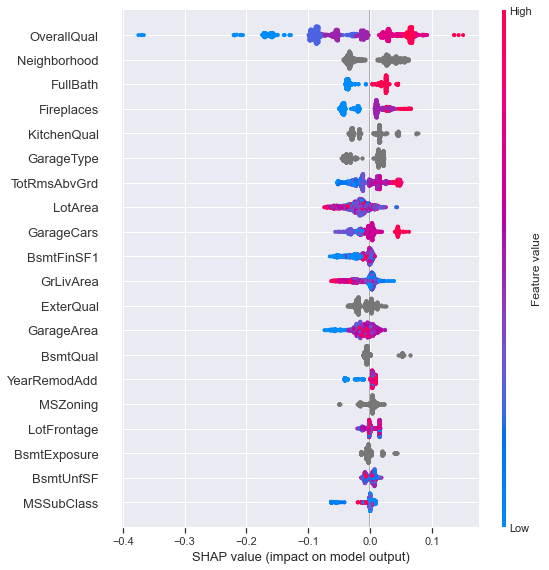

In [31]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [33]:
train_X.columns[:12]

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

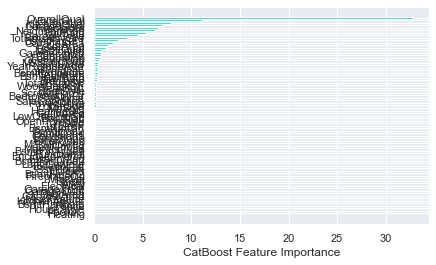

In [34]:
sorted_feature_importance = clf.feature_importances_.argsort()
plt.barh(train_X.columns[sorted_feature_importance],clf.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [35]:
test = test.applymap(str)
pred = clf.predict(test)

In [36]:
submission = pd.DataFrame()
sample_submission = pd.read_csv('input/sample_submission.csv',header = 0)
submission['Id'] = sample_submission.Id
submission['SalePrice'] = np.exp(pred)
submission.to_csv('submission.csv', index=False)
submission.head(5)

,Id,SalePrice
0,1461,146018.671937
1,1462,167725.415463
2,1463,186509.504145
3,1464,219845.102292
4,1465,234752.727269


In [37]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'first try'

100%|██████████████████████████████████████| 33.6k/33.6k [00:03<00:00, 9.38kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques